In [26]:
from StepperLib import Stepper, Stepper_ULN2003
from servo.servo import Servo
from pyfirmata2 import ArduinoMega, Arduino
from time import sleep
from sympy import cos, sin, atan2
from sympy.matrices import Matrix
from numpy import pi
import matplotlib.pyplot as plt
import numpy as np
import math

In [23]:
def inv_kin(position, lengths=(35, 30, 30)):
    """
    x : Rover forwardd
    y : Rover right
    z : Rover up
    """
    # Ideally l1+l2 < x < l1+l2+l3
    x, y, z = position
    l1, l2, l3 = lengths
    
    base_angle = math.atan2(y, x)
    deg_base_angle = (180/pi)*base_angle
    
    # parallel handling
    kx = x - l3 # l1*s1 + l2*s12
    kz = z      # l1*c1 + l2*c12

    c2 = (kx**2 + kz**2 - l1**2 - l2**2)/(2*l1*l2)
    s2 = np.sqrt(1-c2**2)
    theta_2 = float(atan2(s2, c2))

    M = Matrix([
        [l1+l2*c2, l2*s2],
        [-l2*s2  , l1+l2*c2]
        ])
    M_inv = M.inv()
    s1, c1 = M_inv*Matrix(2, 1, [kx, kz])
    theta_1 = float(atan2(s1, c1))

    theta_3 = pi/2 - theta_1 - theta_2

    angles = (theta_1, theta_2, theta_3)
    Plot(position, angles, lengths)
    deg_angles = ((180/pi)*theta_1, (180/pi)*theta_2, (180/pi)*theta_3)
    return deg_base_angle, *deg_angles

def Plot(position, angles, lengths=(35, 30, 30)):
    x, y, z = position
    l1, l2, l3 = lengths
    a1, a2, a3 = angles
    
    plt.xlim((-50, 75))
    plt.ylim((-50, 75))
    
    xs = [0, l1*sin(a1), l1*sin(a1)+l2*sin(a1+a2), l1*sin(a1)+l2*sin(a1+a2)+l3*sin(a1+a2+a3)]
    zs = [0, l1*cos(a1), l1*cos(a1)+l2*cos(a1+a2), l1*cos(a1)+l2*cos(a1+a2)+l3*cos(a1+a2+a3)]

    plt.plot(xs, zs)
    plt.plot(x, z, 'ro')

    kx = x - l3 # l1*s1 + l2*s12
    kz = z      # l1*c1 + l2*c12
    plt.plot(kx, kz, 'ro')
    plt.plot(0, 0, 'ro')
    plt.show()

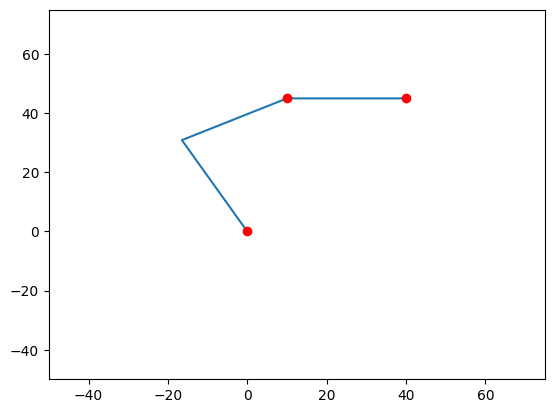

(-26.56505117707799, -28.072486935852965, 90.0, 28.072486935852968)


In [25]:
print(inv_kin((40, -20, 45)))

In [ ]:
# Which arduino you're using?
arduino = ArduinoMega

board = arduino(arduino.AUTODETECT)
print("Communication started...")

# Base stepper pins:
dir_pin = 1
step_pin = 2
micro_step_pins = (3, 4, 5)
# Servo 1:
servo1_pin = 6
# Servo 2:
servo2_pin = 7
# Servo 3:
servo3_pin = 8
# Gripper stepper pins:
gripper_pins = (9, 10, 11, 12)

base = Stepper(board=board, dir_pin=dir_pin, step_pin=step_pin, micro_step_pins=micro_step_pins)
servo1 = Servo(board=board, pin=servo1_pin)
servo2 = Servo(board=board, pin=servo2_pin)
servo3 = Servo(board=board, pin=servo3_pin)
gripper = Stepper_ULN2003(board=board, pins=gripper_pins)

In [ ]:
pos = tuple(map(int, input("Enter position separated by ',' (e.g. x, y, z): ").split(", ")))
lengths = (35, 30, 30)
base_angle, theta_1, theta_2, theta_3 = inv_kin(pos, lengths)

# Set base stepper angle
base.turn_angle(base_angle)

# Set hinge servo angles
servo1.turn_angle(theta_1)
servo2.turn_angle(theta_2)
servo3.turn_angle(theta_3)

# Set number of rotations for gripper stepper
gripper.rotate(num_rotations=1, direction=True)